In [1]:
# chatgpt prompt: "code up a gabor filter bank model of mouse primary visual cortex in python"

#cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi=0, ktype=cv2.CV_32F)
# Parameters:
# ksize: It is the size of the filter kernel (width, height) in pixels. This can be a tuple or a single integer value.
# sigma: (receptive field size) Standard deviation of the Gaussian envelope.
# theta: (orientation tuning) Orientation of the filter in degrees.
# lambd: (spatial frequency) Wavelength of the sinusoidal factor.
# gamma: Spatial aspect ratio (ellipticity) of the filter.
# psi: (phase) Phase offset of the filter in degrees. This is an optional parameter and its default value is 0.
# ktype:  Data type of the filter coefficients. This is an optional parameter and its default value is cv2.CV_32F, which represents a 32-bit floating-point data type.

# useful links: https://stackoverflow.com/questions/30071474/opencv-getgaborkernel-parameters-for-filter-bank
# https://medium.com/@anuj_shah/through-the-eyes-of-gabor-filter-17d1fdb3ac97
# https://cvtuts.wordpress.com/

# ksize: On varying ksize, the size of the convolution kernel varies. In the code above we modify the parameter ksize, 
# while keeping the kernel square and of an odd size. 
# We observe that there is no effect of the size of the convolution kernel on the output image. 
# This also implies that the convolution kernel is scale invariant, since scaling the kernel’s size is analogous to scaling the size of the image.

(300, 480)


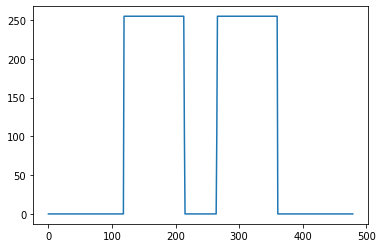

53 33


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import os
import glob
from scipy.io import savemat

imscale = 0.25 # SCALE IMAGE DOWN TO 1/4 ON EITHER AXIS TO REDUCE COMPUTATION TIME
wcfg0_blank = cv2.resize(cv2.imread('100000.tif', cv2.IMREAD_GRAYSCALE), (0,0),fx = imscale, fy = imscale)
print(wcfg0_blank.shape)

plt.plot(wcfg0_blank[int(wcfg0_blank.shape[0]/2),:])
plt.show()

horzmidlinecumsum = np.cumsum((wcfg0_blank[int(wcfg0_blank.shape[0]/2),:])>128)
npix16deg = np.count_nonzero(horzmidlinecumsum==horzmidlinecumsum[int(wcfg0_blank.shape[1]/2)])
npix10deg = np.round(npix16deg*10/16).astype(int)
print(npix16deg, npix10deg) # 53, 33

# impath = 'C:\\Users\\USER\\GitHub\\Analyze_IC_OpenScope_v240130\\visICtxiwcfg1'
# impath = 'GitHub\\Analyze_IC_OpenScope_v240130\\visICtxiwcfg1\\'
# wcfg1_imageset = glob.glob('C:\\Users\\USER\\GitHub\\Analyze_IC_OpenScope_v240130\\visICtxiwcfg1\\*.tif', recursive=True)

impath = '/Users/hyeyoung/Documents/CODE/Display_IC/visOpenScope/visICtxiwcfg1/'
wcfg1_imageset = glob.glob('/Users/hyeyoung/Documents/CODE/Display_IC/visOpenScope/visICtxiwcfg1/*.tif', recursive=True)


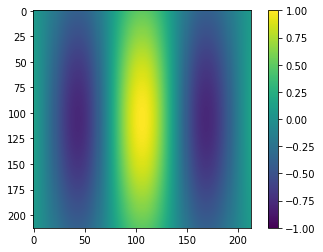

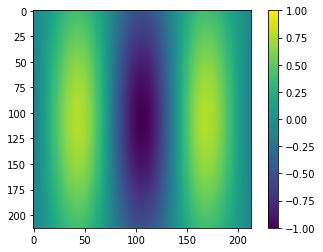

In [5]:
# CODE TO TEST GABOR KERNEL AND FILTERED IMAGE

# if filter size is sufficiently big, rf_size does not make a difference
# if rf_size is equal to or larger than filter size, rf_size does not make a difference on filtered image
# filter size should be the same as lambd (wavelength) to have one cycle show up
# when rf_size is too small relative to lamd, orientation selectivity is lost (circular on field)

# in gabor filter, lambda determines the distance between on and off subfields of a simple cell. 
# it is more appropriate to interpret this as receptive field size rather than preferred spatial frequency
# although, according to Fig 11 of Niell & Stryker 2008, these two are related
rf_size = np.floor(2*npix16deg).astype(int)
theta = 0 # preferred orientation
phase = 0 # preferred phase
lambd = (rf_size/10)/0.08 # (pix per deg)/(cycles per deg) = pix per cycle
filter_size = rf_size

num_phase = 2  # Number of phases v0 36
kernels=[]
for phase in np.arange(0, 2*np.pi, 2*np.pi/num_phase):
    sigma = rf_size / np.sqrt(2 * np.log(2)) # Convert FWHM to 2*sigma
    kernel = cv2.getGaborKernel((rf_size*2, rf_size*2), sigma, theta, lambd, 1, phase)
    kernels.append(kernel)

    plt.imshow(kernel)
    plt.clim([-1,1])
    plt.colorbar()
    plt.show()



#     filtered_img = cv2.filter2D(image, cv2.CV_8UC3, kernel)
#     plt.imshow(filtered_img)
#     plt.title('filter size '+str(filter_size) + ' rf size '+ str(rf_size))
#     plt.show()

#     plt.imshow(image)


In [23]:
def gabor_filter_bank(num_ori, num_phase, spatial_frequency, receptive_field_size):
    filters = []
    for theta in np.arange(0, np.pi, np.pi/num_ori):
        for phase in np.arange(0, 2*np.pi, 2*np.pi/num_phase):
            for lambd in spatial_frequency:  # Adjust range for desired spatial frequency
                for rf_size in receptive_field_size:
                    sigma = rf_size / np.sqrt(2 * np.log(2))  # Convert FWHM to sigma
                    kernel = cv2.getGaborKernel((rf_size*2, rf_size*2), sigma, theta, lambd, 1, phase)
                    filters.append(kernel)
    return filters

def apply_filter_bank(image, filters):
    responses = []
    for filter in filters:
        filtered_img = cv2.filter2D(image, cv2.CV_8UC3, filter)
        responses.append(filtered_img)
    return responses

tic = time.time()
# SCALE IMAGE DOWN TO 1/4 ON EITHER AXIS TO REDUCE COMPUTATION TIME
num_ori = 4  # Number of orientations 40-500: 0.35 resolution according to stringer, 4.8 resolution according to rumyantsev, 4.6 resolution according to behavior paper
num_phase = 1  # Number of phases v0 36
spatial_frequency = [lambd] # (pix per deg)/(cycles per deg) = pix per cycle  # lambda values
receptive_field_size = [rf_size]  # Receptive field sizes: 128 pixels=10 degrees, 205 pixels = 16 degrees

filters = gabor_filter_bank(num_ori, num_phase, spatial_frequency, receptive_field_size) # 1.6s for 6480 filters
print(time.time() - tic)
    
    


0.0049440860748291016


/Users/hyeyoung/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


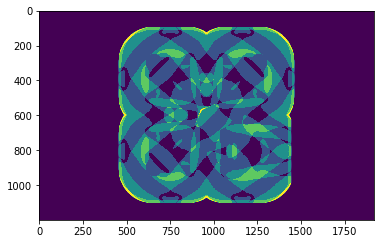

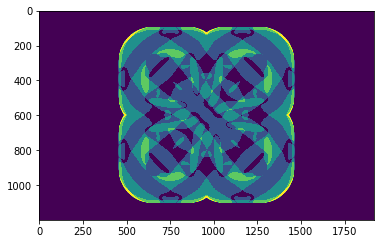

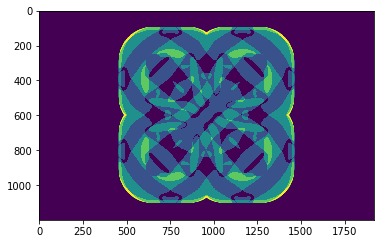

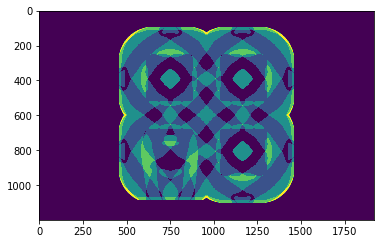

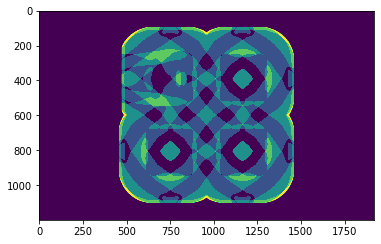

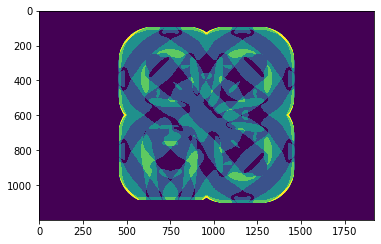

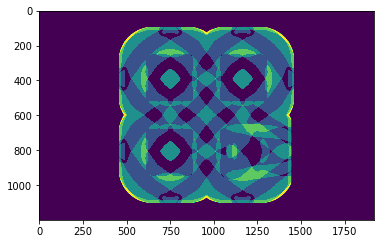

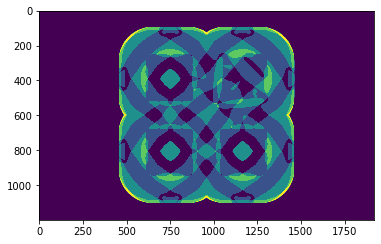

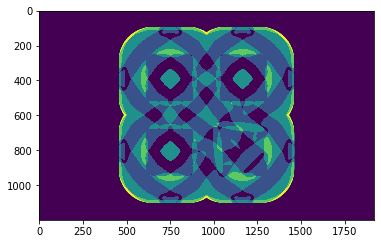

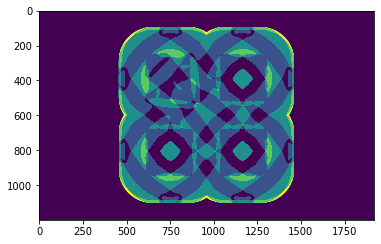

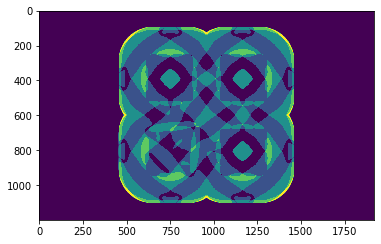

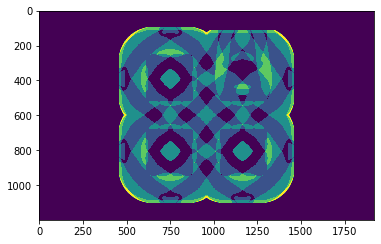

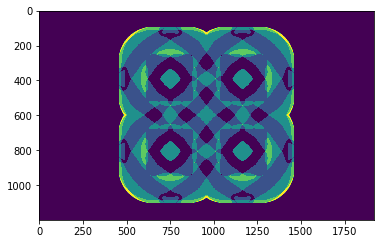

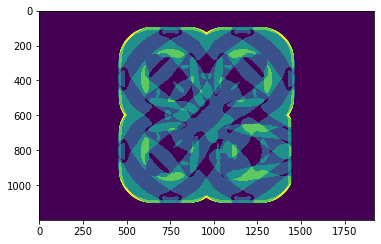

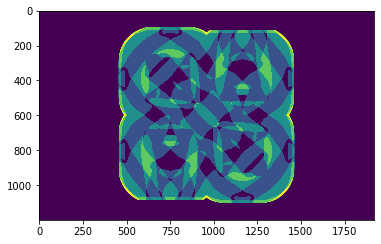

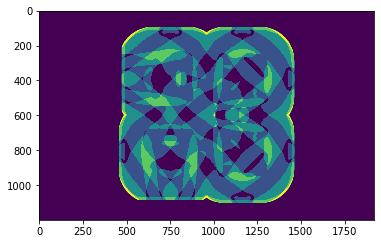

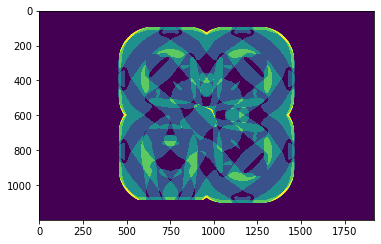

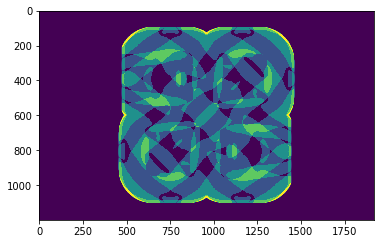

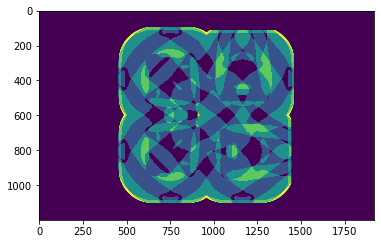

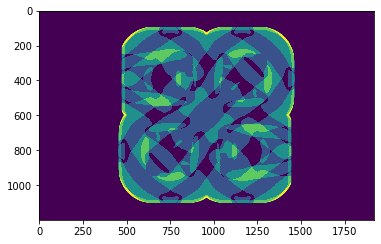

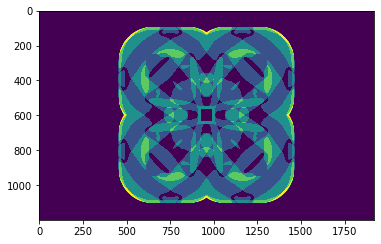

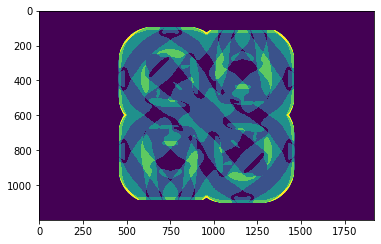

In [24]:
# total time ~6min
tic = time.time()
allresps = []
flatresp =[]
for filename in wcfg1_imageset:
    image = cv2.resize(cv2.imread(filename, cv2.IMREAD_GRAYSCALE), (0,0),fx = 1, fy = 1)    
    responses = apply_filter_bank(image, filters) # 16s for 6480 filters
    plt.figure()
    plt.imshow(np.mean(np.array(responses).astype(float),0))

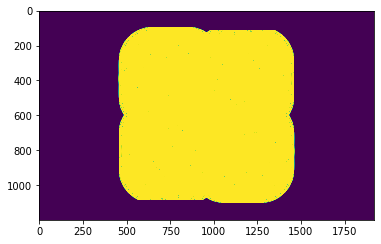

In [22]:
    plt.imshow(np.mean(np.array(responses).astype(float),0))

In [7]:
# total time ~6min
tic = time.time()
allresps = []
flatresp =[]
for filename in wcfg1_imageset:
    image = cv2.resize(cv2.imread(filename, cv2.IMREAD_GRAYSCALE), (0,0),fx = imscale, fy = imscale)    
    responses = apply_filter_bank(image, filters) # 16s for 6480 filters
    allresps.append(responses)
    tempflat = np.array(responses).flatten()
    flatresp.append(tempflat)
    print(time.time() - tic)


0.44889116287231445
0.8943910598754883
1.3374919891357422
1.7725512981414795
2.2060811519622803
2.635385274887085
3.064918041229248
3.4890670776367188
3.9158809185028076
4.366119146347046
4.796405076980591
5.233015060424805
5.662176132202148
6.101560115814209
6.522039175033569
6.943618059158325
7.36265230178833
7.7782652378082275
8.195293188095093
8.613665103912354
9.031551122665405
9.449318170547485


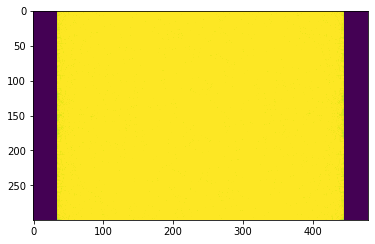

In [11]:
plt.imshow(np.mean(responses,0))

In [5]:
imlabel = []
for filename in wcfg1_imageset:
#     print(filename)
    tempimlab = filename.split('\\')[-1].split('.')[0][-4:]
    print(tempimlab)
    imlabel.append(tempimlab)

# print(len(wcfg1_imageset))

0000
0101
0105
0106
0107
0109
0110
0111
0506
0511
1105
1109
1201
1299
1301
1302
1303
1304
1305
1306
1307
1308


In [6]:
tic = time.time()
allnormresps = []
for filename in wcfg1_imageset:
    image = cv2.resize(cv2.imread(filename, cv2.IMREAD_GRAYSCALE), (0,0),fx = imscale, fy = imscale)    
    responses = apply_filter_bank(image/255.0, filters) # 16s for 6480 filters
    allnormresps.append(responses)
    print(time.time() - tic)

np.array_equal( np.array(allresps), np.array(allnormresps) )

# plt.imshow(image/255.0)
# plt.colorbar()
# plt.show()

1.4248652458190918
2.72027325630188
3.928140878677368
5.121305704116821
6.359290838241577
7.554449081420898
9.376334428787231
10.570503950119019
11.767409086227417
12.998110294342041
14.205276489257812
15.445854425430298
16.631009817123413
17.824905395507812
19.006765127182007
20.207929611206055
21.404289722442627
22.585445642471313
24.101786375045776
25.640490293502808
27.34345531463623
28.58812165260315


False

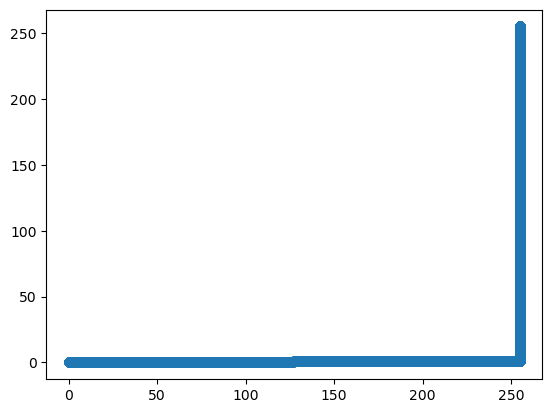

In [7]:
plt.plot(np.array(allresps[0][0]).reshape((-1)), np.array(allnormresps[0][0]).reshape((-1)), 'o')

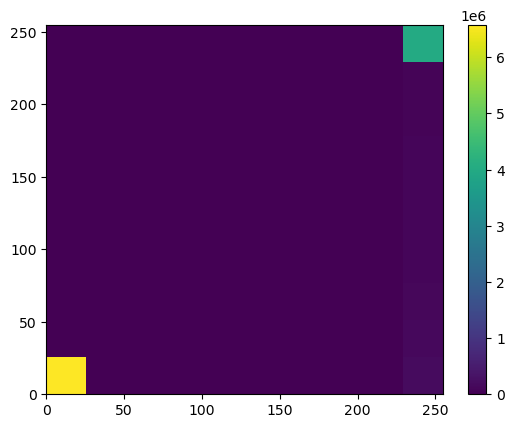

In [14]:
plt.hist2d(np.array(allresps[0]).reshape((-1)), np.array(allnormresps[0]).reshape((-1)) )
plt.colorbar()
plt.show()

In [ ]:
print(len(responses))
print(responses[0].shape)

matdict = {'imscale':imscale, 'npix16deg':npix16deg, 'num_ori':num_ori, 'num_phase':num_phase, 'spatial_frequency':spatial_frequency, 
           'kernels':kernels, 'receptive_field_size':receptive_field_size, 'imlabel':imlabel, 'allresps':allresps}
matfn = 'C:\\Users\\USER\\GitHub\\Analyze_IC_OpenScope_v240130\\visICtxiwcfg1\\ICwcfg1_gaborfiltbank_normresp'+str(rf_size)+'.mat'
print(matfn)
savemat(matfn, matdict)


In [ ]:
cossimmat = np.zeros((len(wcfg1_imageset), len(wcfg1_imageset)))
tic = time.time()
for ii in np.arange(len(wcfg1_imageset)):
    for jj in np.arange(ii,len(wcfg1_imageset)):
        A = flatresp[ii].astype(float)
        B = flatresp[jj].astype(float)
        tempcossim = np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))
        cossimmat[ii,jj] = tempcossim
        cossimmat[jj,ii] = tempcossim
    print(ii, jj, time.time() - tic) # 3.5s per image pair total 808s = 14min

In [ ]:
plt.imshow(cossimmat)
plt.xticks(ticks=np.arange(len(imlabel)), labels=imlabel, rotation=90)
plt.yticks(ticks=np.arange(len(imlabel)), labels=imlabel)
plt.colorbar()
plt.show()

In [ ]:
traintrialtypes = ['0106', '0107', '0110', '0111']
REttrialtypes = ['1105', '1109']
xinds = np.isin(imlabel, traintrialtypes)
yinds = np.isin(imlabel, REttrialtypes)
print(cossimmat[yinds,:][:,xinds])

plt.imshow(cossimmat[yinds,:][:,xinds])
plt.xticks(ticks=np.arange(len(traintrialtypes)), labels=traintrialtypes, rotation=90)
plt.yticks(ticks=np.arange(len(REttrialtypes)), labels=REttrialtypes)
plt.colorbar()
plt.show()

In [ ]:
matdict = {'imscale':imscale, 'num_ori':num_ori, 'num_phase':num_phase, 'spatial_frequency':spatial_frequency, 'receptive_field_size':receptive_field_size, 'imlabel':imlabel, 'cossimmat':cossimmat}
matfn = 'C:\\Users\\USER\\GitHub\\Analyze_IC_OpenScope_v240130\\visICtxiwcfg1\\ICwcfg1_gaborfiltbank_cossimnorm'+str(rf_size)+'.mat'
print(matfn)
savemat(matfn, matdict)


In [ ]:
# need to cast vector as float type before computing cosine similarity
print(ii,jj)
tempcossim = np.dot(flatresp[ii],flatresp[jj])/(np.linalg.norm(flatresp[ii])*np.linalg.norm(flatresp[jj]))
print(tempcossim)
tempcossim = np.dot(flatresp[ii].astype(float),flatresp[jj].astype(float))/(np.linalg.norm(flatresp[ii].astype(float))*np.linalg.norm(flatresp[jj].astype(float)))
print(tempcossim)

In [ ]:
print(np.arange(0,num_phase,num_phase/2, dtype=int))

In [ ]:
imind = 1
rsresp = np.reshape(flatresp[imind].astype(float), (num_phase, num_ori, wcfg0_blank.shape[0], wcfg0_blank.shape[1]) )

image = cv2.resize(cv2.imread(wcfg1_imageset[imind], cv2.IMREAD_GRAYSCALE), (0,0),fx = imscale, fy = imscale)
plt.imshow(image)
plt.colorbar()
plt.show()

rsrespavgoris = np.mean(rsresp, axis=(0,1))
plt.imshow(rsrespavgoris)
plt.colorbar()
plt.show()

for ii in np.arange(0,num_phase,num_phase/2, dtype=int):
    rsrespavgoris = np.mean(rsresp[ii], axis=0)
    plt.imshow(rsrespavgoris)
    plt.colorbar()
    plt.show()

    

print(rsresp.shape)
print(rsrespavgoris.shape)

In [ ]:
(num_phase, num_ori, wcfg0_blank.shape[0], wcfg0_blank.shape[1])
# for theta in np.linspace(0, np.pi, num_ori):
#     for phase in np.linspace(0, 2*np.pi, num_phase):

In [ ]:
responses = apply_filter_bank(image.astype('float'), filters)
plt.imshow(responses[0])
plt.show()

In [ ]:
responses = apply_filter_bank(image, filters)
plt.imshow(responses[0])
plt.show()

In [ ]:
def apply_gaussian_low_pass(image, sigma):
    # Convert image to grayscale if it's a color image
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    
    # Apply Gaussian blur
    filtered_image = cv2.GaussianBlur(gray_image, (0, 0), sigma)
    
    return filtered_image

# Read the input image
ii=4
image = cv2.resize(cv2.imread(wcfg1_imageset[ii], cv2.IMREAD_GRAYSCALE), (0,0),fx = imscale, fy = imscale)    

# Set the sigma value for Gaussian blur
sigma = npix10deg / np.sqrt(2 * np.log(2))


# Apply Gaussian low-pass filter
filtered_image = apply_gaussian_low_pass(image, sigma)

# # this takes a long time...
# # Display original and filtered images
# cv2.imshow('Original Image', image)
# cv2.imshow('Filtered Image', filtered_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [ ]:
im2plt = ['0106', '0506', '0111', '0511'];
factorsigma = 0.5 # use to test what the images would look like with different RF sizes. 1 according to code above,.

for imlab in im2plt:
    imfn = wcfg1_imageset[np.where(np.array(imlabel)==imlab)[0][0]]
    image = cv2.resize(cv2.imread(imfn, cv2.IMREAD_GRAYSCALE), (0,0),fx = imscale, fy = imscale)    
    filtered_image = apply_gaussian_low_pass(image, factorsigma*sigma)

#     plt.imshow(image)
#     plt.show()

    plt.imshow(filtered_image)
    plt.show()


In [ ]:
a = np.argwhere(np.array(imlabel)==imlab)
print(a[0][0])

In [ ]:
np.array(imlabel)==imlab